# Final notebook

This is the main notebook for the midterm submission from RWS group 3

## Table of contents
1. Analysis of incident data
2. The travel time of the road sections

In [1]:
## Importing all neccesary modules
%matplotlib inline
import geopandas as gpd
import folium 
import json
import pandas as pd
import numpy as np

from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import pickle
import networkx as nx

## 1. Analysis of incident data

### 1.1 Preparation work

In [2]:
# Functions

def DutchRDtoWGS84(rdX, rdY):
    """ Convert DutchRD to WGS84
    """
    RD_MINIMUM_X = 11000
    RD_MAXIMUM_X = 280000
    RD_MINIMUM_Y = 300000
    RD_MAXIMUM_Y = 630000
    if (rdX < RD_MINIMUM_X or rdX > RD_MAXIMUM_X
        or rdY < RD_MINIMUM_Y or rdY > RD_MAXIMUM_Y):
        resultNorth = -1
        resultEast = -1
        return resultNorth, resultEast
    # else
    dX = (rdX - 155000.0) / 100000.0
    dY = (rdY - 463000.0) / 100000.0
    k = [[3600 * 52.15517440, 3235.65389, -0.24750, -0.06550, 0.0],
        [-0.00738   ,   -0.00012,  0.0    ,  0.0    , 0.0],
        [-32.58297   ,   -0.84978, -0.01709, -0.00039, 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00530   ,    0.00033,  0.0    ,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    l = [[3600 * 5.38720621,    0.01199,  0.00022,  0.0    , 0.0],
        [5260.52916   ,  105.94684,  2.45656,  0.05594, 0.00128],
        [-0.00022   ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [-0.81885   ,   -0.05607, -0.00256,  0.0    , 0.0],
        [0.0       ,    0.0    ,  0.0    ,  0.0    , 0.0],
        [0.00026   ,    0.0    ,  0.0    ,  0.0    , 0.0]]
    resultNorth = 0
    resultEast = 0
    powX = 1

    for p in range(6):
        powY = 1
        for q in range(5):
            resultNorth = resultNorth + k[p][q] * powX * powY / 3600.0
            resultEast = resultEast + l[p][q] * powX * powY / 3600.0
            powY = powY * dY
        powX = powX * dX
    return resultNorth, resultEast

def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY

def calc_distance(line_wkt):
    line = ogr.CreateGeometryFromWkt(line_wkt)
    points = line.GetPoints()
    d = 0
    for p0, p1 in zip(points, points[1:]):
        d = d + geodesic(p0, p1).m
    return d

if __name__=="__main__":
    x, y = WGS84toDutchRD(4.33, 52.04)
    print(DutchRDtoWGS84(x, y))

(52.03999999894767, 4.330000046074026)


In [3]:
#Extract subnetwork
highway_shapefile = 'Shapefiles/Snelheid_Wegvakken.shp'
network_temp = gpd.read_file(highway_shapefile)


<Axes: >

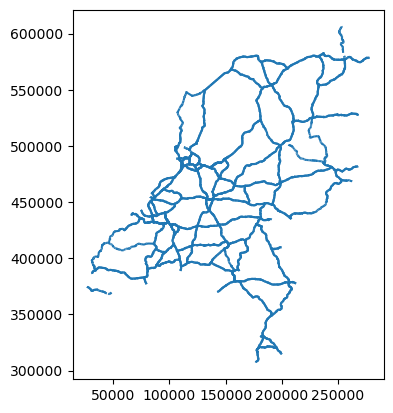

In [4]:
network_temp.plot()

### 1.2 Loading data

In [5]:
df = pd.read_csv('incidents19Q3Q4.csv')
df.columns = ['index', 'id', 'type', 'start_time','end_time', 'road_number','longitude','latitude']
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df.head()

,index,id,type,start_time,end_time,road_number,longitude,latitude
0,0,A-ALL-IM19087676NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A1,4.974663,52.346931
1,3,A-ALL-IM19087677NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A9,4.716725,52.514820
2,5,A-ALL-IM19087678NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A9,4.738364,52.609730
3,7,A-ALL-IM19087679NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A35,6.824692,52.204929
4,174938,A-ALL-IM19087680NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A4,4.346407,52.041920


### 1.3 Data Filtering: 
A function that can:
- (1) Delete the incidents which are not occured on the high ways 
- (2) Delete the incidents which the values for road number is missing 
- (3) Change name of all roads 'hrb'
- (4) Delete the incidents that are out of the border of the Netherlands 

In [6]:
def data_filter(data_input):
    data_input = df.dropna()
    data_input.loc[:,'road_number'] = data_input['road_number'].replace({'A12 hrb':'A12', 'A16 hrb':'A16', 'A2 hrb':'A2'})
    new_data = data_input[data_input['road_number'].str.startswith('A')]
    new_data.drop(new_data.loc[new_data['index'] == 183130].index, inplace=True)
    
    return new_data
incidents_df = data_filter(df)

C:\Users\yanzh\AppData\Local\Temp\ipykernel_13636\2717485259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data.drop(new_data.loc[new_data['index'] == 183130].index, inplace=True)


In [7]:
incidents_df

,index,id,type,start_time,end_time,road_number,longitude,latitude
0,0,A-ALL-IM19087676NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A1,4.974663,52.346931
1,3,A-ALL-IM19087677NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A9,4.716725,52.514820
2,5,A-ALL-IM19087678NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A9,4.738364,52.609730
3,7,A-ALL-IM19087679NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A35,6.824692,52.204929
4,174938,A-ALL-IM19087680NLD_1,vehicle_obstruction,2019-08-28 12:11:00,2019-12-11 11:32:00,A4,4.346407,52.041920
...,...,...,...,...,...,...,...,...
88842,374078,RWS03_833968_1,vehicle_obstruction,2019-12-31 23:36:00,2019-12-31 23:36:00,A4,4.313686,51.442677
88843,374079,RWS03_833969_1,vehicle_obstruction,2019-12-31 23:36:00,2019-12-31 23:36:00,A67,5.636626,51.422424
88845,374081,RWS03_833971_1,vehicle_obstruction,2019-12-31 23:39:00,2019-12-31 23:39:00,A4,4.713698,52.278961
88849,374085,RWS03_833975_1,vehicle_obstruction,2019-12-31 23:55:00,2019-12-31 23:55:00,A4,4.313686,51.442677


### 1.4 Data visualization

#### 1.4.1 Mark all incidents at the road network in heatmap

In [8]:
# def draw_incidents(filter_type, keyword):

#     # Define a new map
#     m = folium.Map(location=[52.399190, 4.893658])

#     if filter_type == 'Incident_type':
#         new_data = incidents_df.loc[incidents_df['type'] == keyword]
#         # Extract the latitude and longitude as a list of lists
#         heat_data = [[row['latitude'], row['longitude']] for _, row in new_data.iterrows()]
#         # Create a heatmap layer
#         HeatMap(heat_data).add_to(m)
#     return m

# map_new = draw_incidents('Incident_type', 'accident')
# map_new


#### 1.4.2 Analysis of time periods when incidents occurs (starting time)

Draw a bar chart show the distribution of time when incidents occurs

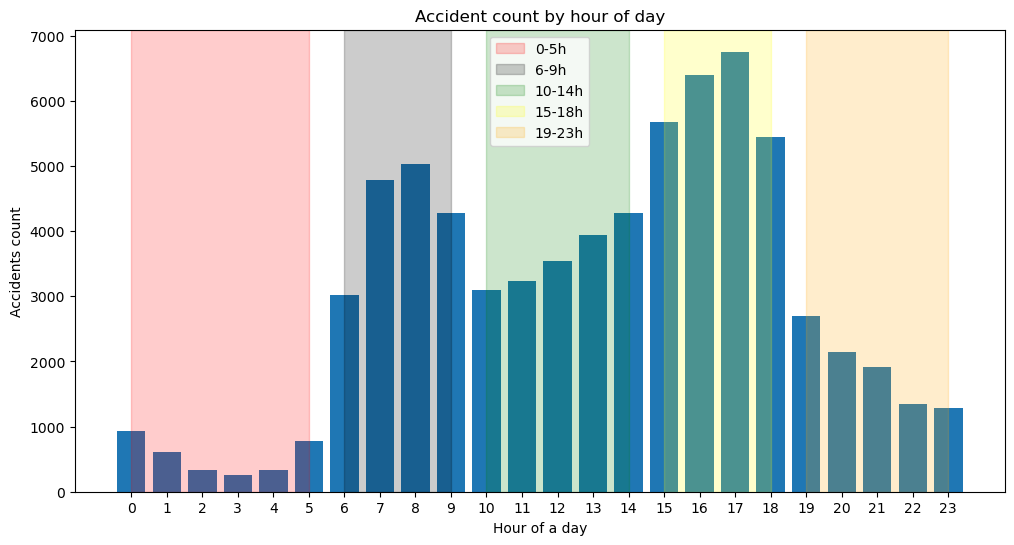

In [9]:
incidents_df['hour_of_day'] = incidents_df['start_time'].apply(lambda x: x.hour)
hourly_counts = incidents_df.groupby('hour_of_day').size().reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
plt.bar(hourly_counts['hour_of_day'], hourly_counts['accident_count'])
plt.xlabel('Hour of a day')
plt.ylabel('Accidents count')
plt.title('Accident count by hour of day')
plt.xticks(hourly_counts['hour_of_day'])

plt.axvspan(0, 5, alpha=0.2, color='red', label='0-5h')
plt.axvspan(6, 9, alpha=0.2, color='black', label='6-9h')
plt.axvspan(10, 14, alpha=0.2, color='green', label='10-14h')
plt.axvspan(15, 18, alpha=0.2, color='yellow', label='15-18h')
plt.axvspan(19, 23, alpha=0.2, color='orange', label='19-23h')
plt.legend()

plt.show()

Calculate the probability of accident of time of a day

In [10]:
# Calculate the probability of time of a day for incident
pro_0_5h = hourly_counts['accident_count'][:6].sum() / hourly_counts['accident_count'].sum()
pro_6_9h = hourly_counts['accident_count'][6:10].sum() / hourly_counts['accident_count'].sum()
pro_10_14h = hourly_counts['accident_count'][10:15].sum() / hourly_counts['accident_count'].sum()
pro_15_18h =hourly_counts['accident_count'][15:19].sum() / hourly_counts['accident_count'].sum()
pro_19_23h = hourly_counts['accident_count'][19:].sum() / hourly_counts['accident_count'].sum()

result_data = {
    'Time Range': ['0-5 hours', '6-9 hours', '10-14 hours', '15-18 hours', '19-23 hours'],
    'Probability': [pro_0_5h, pro_6_9h, pro_10_14h, pro_15_18h, pro_19_23h]
}

pro_time = pd.DataFrame(result_data)
pro_time

,Time Range,Probability
0,0-5 hours,0.044875
1,6-9 hours,0.237173
2,10-14 hours,0.251054
3,15-18 hours,0.336449
4,19-23 hours,0.130450


#### 1.4.3 Analysis of day of week when incidents occurs

Calculate the probability of accident of time of week

In [11]:
# incidents_df['day of week'] = incidents_df ['start_time'].dt.dayofweek
# weekly_count = incidents_df['day of week'].value_counts(normalize=True)
# day_mapping = {
#     0: 'Monday',
#     1: 'Tuesday',
#     2: 'Wednesday',
#     3: 'Thursday',
#     4: 'Friday',
#     5: 'Saturday',
#     6: 'Sunday'
# }
# weekly_count.index = weekly_count.index.map(day_mapping)

# pro_weekly = pd.DataFrame({
#     'Day of Week': weekly_count.index,
#     'Probability': weekly_count.values
# })
# pro_weekly 

Draw a bar chart to visualize the probability

In [12]:
# plt.figure(figsize=(12,6))
# plt.bar(pro_weekly['Day of Week'], pro_weekly['Probability'])
# plt.ylabel('Probability')
# plt.title('Probability of incident occuring on different days of a week')

#### 1.4.4 Analysis of accident frequency and duration time in each highway

In [13]:
# # count the number of accidents in each road
# accidents_number = incidents_df.groupby('road_number').size()
# accidents_df = accidents_number.reset_index()
# accidents_df.columns = ['road_number', 'accidents_number']

# # count the average lasting time for each road
# incidents_df['Duration_time'] = (incidents_df['end_time'] - incidents_df['start_time']).dt.total_seconds() / 60
# average_duration_by_road = incidents_df.groupby('road_number')['Duration_time'].mean()
# duration_df = average_duration_by_road.reset_index()
# duration_df.columns = ['road_number', 'average_duration']

# # Mix them and create the new dataframe
# road_number_counts = pd.merge(accidents_df, duration_df, on='road_number', how='left')

### 1.5 Show the incident hot spots

Here we use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) clustering algorithm to show hotspots of incident, which is based on density of incidents in map

In [14]:
# def draw_clusters(eps, min_samples, data):
   
#     # Create a DBSCAN clustering model
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine', algorithm='ball_tree')

#     # Fit the model to the latitude and longitude data
#     dbscan.fit(data[['latitude', 'longitude']].values)

#     # Assign cluster labels to data points
#     data['cluster'] = dbscan.labels_

#     # Filter out noise points (-1 labels)
#     clustered_data = data[data['cluster'] != -1]

#     m = folium.Map(location=[52.399190, 4.893658], zoom_start=8, zoom_control=False)

#     # Create a MarkerCluster layer for clustered data
#     marker_cluster = MarkerCluster().add_to(m)

#     # Add markers for clustering
#     for _, row in clustered_data.iterrows():
#         popup_text = f"Cluster: {row['cluster']}<br>Type: {row['type']}<br>Index: {row['index']}"
#         folium.Marker([row['latitude'], row['longitude']], icon=None, popup=popup_text).add_to(marker_cluster)

#     return m


# # Call the function to visualize clusters with markers and centroids
# clustered_map = draw_clusters(eps=0.1, min_samples=100, data=incidents_df)
# clustered_map


Then we can show the specific longitude and langtitude of each hotspot 

## 2. The travel time of the road sections

In this section the speed of the road section will be determined. Together with the length of each road section, the travel time of each section can be deterined. For the full notebook with all explanations. See **speed_network_data.ipynb**. 

This section will only show the results obtained from the speed_network_data notebook. 

First there is the following dataframe. It has been obtained by combining the given shapefiles, open source wkd ("Wegkenmerkendatabase") data about the maximum speed and INWEVA ("INtensiteit WEgVAkken") data which gives traffic intensities on road sections. There was some missing data, which has been filled with data from adjacent road sections.

In [15]:
# road_section_data = pd.read_csv('speed_data.txt', sep=';')
# road_section_data.head()

So far the travel time of each road section has been estimated in optimal conditions (the average speed equals the speed limit) and the speed during peak hours. 

The data from the dataframe has also been converted to a NetworkX graph. This graph can later be used in the optimization methods to calculate the travel time of the shortest path

In [16]:
G = pickle.load(open('NetworkX_graph_new.pickle', 'rb'))

The graph contains all edges with several attributes

In [17]:
# Example of the data of a random edge
G.edges[list(G.edges)[0]]

{'geometry': <LINESTRING (117613.756 426301.388, 117622.09 426302.275, 117634.941 426306....>,
 'Max_speed': 130.0,
 'Road_number': 'A15',
 'Road_section_id': 235252052,
 'Min_travel_time_[s]': 6.2,
 'Peak_travel_time_[s]': 7.5,
 'Peak_speed': 107.7}

## 3. Optimization Methods

From Janine's part

In [18]:
def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY


G = pickle.load(open('NetworkX_graph_new.pickle', 'rb'))

In [19]:
# travel_time function
from scipy import spatial


def travel_time_func(point1, point2, time='min'):
    """This function uses the information given in network X to return the travel time between two points.
        point1 and point2 should be tuples with the coordinates in longitude, latitude.
        if time = 'peak', the peak travel time is used. In all other cases the minimum travel time is used."""

    # Determine which travel times to use
    if time == 'peak':
        time_string = 'Peak_travel_time_[s]'
    else:
        time_string = 'Min_travel_time_[s]'

    # Change points to Dutch system
    p1_x, p1_y = WGS84toDutchRD(point1[0], point1[1]) # inspector
    p2_x, p2_y = WGS84toDutchRD(point2[0], point2[1]) # incident

    # Create numpy matrix from nodes
    A = np.array(list(G.nodes()))

    # Get node closest to each point
    dist_node1, index_node1 = spatial.KDTree(A).query([p1_x, p1_y])
    node1 = (A[index_node1][0], A[index_node1][1])

    dist_node2, index_node2 = spatial.KDTree(A).query([p2_x, p2_y])
    node2 = (A[index_node2][0], A[index_node2][1])

    # Get shortest path between nodes
    route = nx.shortest_path(G, node1, node2, time_string)
    travel_time = nx.shortest_path_length(G, node1, node2, time_string)

    return route, travel_time

From Henry's part

In [20]:
# Create a list of converted coordinates
converted_coordinates = [DutchRDtoWGS84(rd_x, rd_y) for (rd_x, rd_y) in list(G.nodes)]

# Create a Pandas DataFrame from the converted coordinates
node_df = pd.DataFrame(converted_coordinates, columns=['latitude', 'longitude'])

# Display the DataFrame
node_df

,latitude,longitude
0,51.824069,4.844911
1,51.824346,4.848142
2,52.715749,6.522436
3,52.715733,6.525522
4,53.059468,6.049683
...,...,...
13596,53.180362,7.227448
13597,51.589270,4.295737
13598,53.202688,6.634860
13599,52.492715,4.900410


In [21]:
import math
from collections import namedtuple

KdNode = namedtuple('KdNode', 'point left right')

# Build k-d tree
def kdtree(point_list, depth=0):

    if not point_list:
        return None

    k = 2  # 2-dimensional space
    axis = depth % k

    point_list.sort(key=lambda x: x[axis])
    median = len(point_list) // 2

    return KdNode(
        point=point_list[median],
        left=kdtree(point_list[:median], depth + 1),
        right=kdtree(point_list[median + 1:], depth + 1)
    )

# Find the closest point
def closest_node(kdtree, target):
    _, nearest_node_index = kdtree.query(target, k=1)
    return kdtree.data[nearest_node_index]

### K-means method based on travel time starts here

Firstly we select 80% incident data to train the model.

In [22]:
data = incidents_df[['latitude','longitude']].values
num_samples = len(data)
num_samples_keep = int(0.8*num_samples)

#Random distruption data
np.random.shuffle(data)
selected_data = data[:num_samples_keep]
remaining_data = data[num_samples_keep:]


In [23]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
import numpy as np
from scipy.spatial import cKDTree  # Using cKDTree from scipy
import pandas as pd

# Build KD Tree
def build_kd_tree(node_data):
    return cKDTree(node_data)

# Find the closest point
def closest_node(kdtree, target):
    _, nearest_node_index = kdtree.query(target, k=1)
    return kdtree.data[nearest_node_index]

# Custom K-means function
def custom_kmeans_with_travel_time(data, k, max_iterations=5):
    # Build KD Tree
    kdtree = build_kd_tree(node_data)

    # Initialize K-means
    kmeans = KMeans(n_clusters=k, max_iter=max_iterations, n_init=1, random_state=0)

    # Fit K-means to get initial cluster centers
    kmeans.fit(data)

    # Initialize cluster_centers with initial cluster centers
    cluster_centers = kmeans.cluster_centers_

    max_travel_time = 18 * 60  # 18 minutes in seconds

    # Continue reassigning incidents until no reassignments are made
    reassignments_made = True
    while reassignments_made:
        reassignments_made = False
        for i in range(k):
            cluster_center = cluster_centers[i]
            cluster_incidents = data[kmeans.labels_ == i]
            for incident in cluster_incidents:
                _, travel_time = travel_time_func(incident, cluster_center)
                if travel_time > max_travel_time:
                    # Find the nearest node using KD Tree
                    nearest_node = closest_node(kdtree, incident)

                    # Reassign the incident to the nearest cluster
                    cluster_centers[i] = nearest_node
                    reassignments_made = True
                    break

    return kmeans.labels_, cluster_centers

# Use the new KD Tree library
# k = 120
# data = incidents_df[['longitude', 'latitude']].values
# node_data = node_df[['longitude', 'latitude']].values
# cluster_labels, cluster_centers = custom_kmeans_with_travel_time(data, k, max_iterations=5)


In [41]:
import pandas as pd

file_path = 'test_data.txt'  

data = {"Cluster": [], "Center": [], "Max Travel Time": []}
current_cluster = None
center_line = None

with open(file_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    if line.startswith("Cluster"):
        if current_cluster is not None:
            data["Cluster"].append(current_cluster)
            data["Center"].append(center_line)
        current_cluster = int(line.split()[1])
        center_line = None
    elif "Center" in line:
        center_line = [float(coord) for coord in line.split("[")[1].split("]")[0].split()]
    elif "Max Travel Time" in line:
        max_travel_time = float(line.split(":")[1])
        data["Max Travel Time"].append(max_travel_time)

data["Cluster"].append(current_cluster)
data["Center"].append(center_line)

df_1 = pd.DataFrame(data)
with open('test_data.txt', 'r') as file:
    lines = file.readlines()

data = []

# Walk through each line
for line in lines:
    if line.startswith('Cluster'):
        parts = line.split(':')
        cluster_num = parts[0].split()[-1]
        coordinates = parts[1].strip().strip('[]').split()
        coordinate = " ".join(coordinates[::-1])  # Combine and switch the order of coordinates
        data.append([cluster_num, coordinate])  # Store the cluster number and combined coordinates

# Create the DataFrame
df = pd.DataFrame(data, columns=['Inspector Number', 'Location'])  # Use a single 'Location' column

result_df = pd.concat([df, df_1['Max Travel Time']], axis=1)
result_df = result_df.drop('Inspector Number', axis=1)
result_df ['Max Travel Time']= result_df['Max Travel Time'] / 60 
result_df

,Location,Max Travel Time
0,52.04574431 4.50187431,38.565755
1,52.01272177 5.67297483,36.118512
2,52.09236214 5.19670239,41.083424
3,52.57923173 6.19055917,41.047183
4,51.52133068 5.23121567,45.629704
5,51.92267934 4.53683559,45.699784
6,51.03960755 5.82605138,31.413552
7,53.2026885 6.63486046,26.206532
8,52.49408976 4.89588392,133.982430
9,51.42662118 4.08584293,25.767626


In [42]:
result_df['Max Travel Time'].describe()

count     60.000000
mean      49.196885
std       24.355556
min       12.925306
25%       35.995353
50%       44.151027
75%       57.391897
max      159.193393
Name: Max Travel Time, dtype: float64

In [43]:
import folium

m = folium.Map(location=[52.399190, 4.893658], zoom_start=10)

cluster_centers = result_df['Location']

for center in cluster_centers:
    lat, lon = center.split()  
    folium.Marker(location=[float(lat), float(lon)]).add_to(m)

m

